In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

import jax

import icomo

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Model

In [2]:
# Function to calculate the modulating factor 'm' based on provided arguments
def m(args):
    # Calculate the modulating factor 'm' which depends on 'm_max', 'H_thres', 'm_eps', and 'H'
    return args["m_max"] - args["m_max"] / args["H_thres"] * args[
        "m_eps"
    ] * jax.numpy.log(1 + jax.numpy.exp((args["H_thres"] - args["H"]) / args["m_eps"]))


# Function to calculate the testing rate of STI
def lambda_STI(args):
    return (
        args["lambda_0_a"]  # Baseline test rate
        + args["c"]
        * (1 - m(args))
        * args["beta_HIV"]
        * args["H"]
        * (1 - args["P_HIV"])  # HIV dependent term
        + args["lambda_P"]
        * args["P_HIV"]  # Proportional infection rate due to HIV prevalence
    )


# Function to calculate infection from asymptomatic STI individuals
def infect_ia(y, args):
    return (1 - m(args) * (1 - args["P_HIV"])) * args["beta_STI"] * y["Ia_STI"]


# Function to calculate infection from symptomatic STI individuals
def infect_is(y, args):
    return (1 - m(args) * (1 - args["P_HIV"])) * args["beta_STI"] * y["Is_STI"]


# Main model function that defines the differential equations of the system
def model(t, y, args):
    cm = icomo.CompModel(y)  # Initialize the compartmental model

    # Basic STI dynamics
    cm.flow(
        "S_STI", "Ia_STI", args["asymptomatic"] * infect_ia(y, args)
    )  # Susceptible to asymptomatic
    cm.flow(
        "S_STI", "Is_STI", (1 - args["asymptomatic"]) * infect_is(y, args)
    )  # Susceptible to symptomatic
    cm.flow(
        "Ia_STI", "S_STI", args["gamma_STI"]
    )  # Asymptomatic to susceptible (recovery)
    cm.flow("Ia_STI", "T_STI", lambda_STI(args))  # Asymptomatic to tested and treatment
    cm.flow("Is_STI", "T_STI", args["lambda_0"])  # Symptomatic to tested and treatment
    cm.flow(
        "T_STI", "S_STI", args["gammaT_STI"]
    )  # Treatment to susceptible (immunity loss)

    # Vital dynamics (natural death or other forms of removal)
    cm.flow("Ia_STI", "S_STI", args["mu"])  # Death/removal from asymptomatic
    cm.flow("Is_STI", "S_STI", args["mu"])  # Death/removal from symptomatic
    cm.flow("T_STI", "S_STI", args["mu"])  # Death/removal from treatment

    # Return the differential changes
    return cm.dy


# Arguments for the model
args = {
    "beta_HIV": 0.6341 / 360.0,  # HIV infection rate per day
    "beta_STI": 0.0016 * 5.0,  # STI infection rate
    "mu": 1.0 / 45.0 / 360.0,  # Natural death rate per day
    "gamma_STI": 1.0 / 1.32 / 360.0,  # Recovery rate from asymptomatic STI per day
    "gammaT_STI": 1.0 / 14.0,  # Recovery rate from treated STI per day
    "lambda_0_a": 0.0,  # Baseline test rate for asymptomatic STI
    "lambda_0": 0.3 / 11.0,  # Baseline test rate for symptomatic STI
    "lambda_P": 1 / 3 / 360,  # Infection rate due to HIV prevalence
    "asymptomatic": 0.9,  # Proportion of asymptomatic infections
    "m_max": 0.8,  # Maximum modulating factor
    "H_thres": 0.1,  # HIV threshold
    "m_eps": 0.01,  # Small constant for smoothing
    "Phi_r": 40.0,  # Not used in the current model
    "H_tau": 20.0,  # Not used in the current model
    "c": 50.0,  # Scaling factor for HIV interaction term
    "H": 0.0,  # Initial HIV prevalence
    "P_HIV": 0.0,  # Initial proportion of HIV positive individuals
}

# Initial state of the compartments
y0 = {
    "S_STI": 0.99,  # Initial susceptible proportion
    "Ia_STI": 0.009,  # Initial asymptomatic proportion
    "Is_STI": 0.001,  # Initial symptomatic proportion
    "T_STI": 0.0,  # Initial treated proportion
}

In [3]:
# Define the time span for the simulation
ts = np.linspace(0, 3600 * 5, 3600)

# Create an ODE integrator object using the icomo library
integrator_object = icomo.ODEIntegrator(
    ts_out=ts,  # Output time points
    t_0=min(ts),  # Initial time point
    ts_solver=ts,  # Time points for the solver to use
)

# Get the integration function for the model
integrator = integrator_object.get_func(
    model
)  # Returns a function that can be used to solve the ODEs defined in the 'model' function

## Sweep

## Hs, Ps are continuous from 0 to 0.2 and 0 to 1 respectively. Lambda_P with 8 discrete steps

In [4]:
# Define the ranges for H (HIV prevalence) and P (proportion of HIV positive individuals)
Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0

# Define different values for lambda_P (proportional infection rate due to HIV prevalence)
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2.5 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
]

# Generate lambda_P values from 1 to 6 with a step of 0.1
# lambda_P_values = np.linspace(1, 6, 21)

# Dictionary to store results for different lambda_P values
results = {}

# Loop over each lambda_P value
for lambda_P in lambda_P_values:
    res_size = [len(Hs), len(Ps)]  # Determine the size of the result matrices
    res_Ia = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic STI infections
    res_Is = np.zeros(
        res_size
    )  # Initialize result matrix for symptomatic STI infections
    res_T = np.zeros(res_size)  # Initialize result matrix for treated STI infections
    res_infections = np.zeros(res_size)  # Initialize result matrix for total infections
    res_asymp_infections = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic infections
    res_symp_infections = np.zeros(
        res_size
    )  # Initialize result matrix for symptomatic infections
    res_tests = np.zeros(res_size)  # Initialize result matrix for the number of tests
    res_asymp_tests = np.zeros(
        res_size
    )  # Initialize result matrix for the number of tests for asymptomatic
    res_symp_tests = np.zeros(
        res_size
    )  # Initialize result matrix for the number of tests for symptomatic
    check = np.zeros(res_size)  # Initialize matrix to check for convergence

    # Loop over each value of H and P
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            args_mod = args.copy()
            args_mod["H"] = H
            args_mod["P_HIV"] = P
            args_mod["lambda_P"] = lambda_P

            # Integrate the model with the modified arguments
            output = integrator(y0=y0, constant_args=args_mod)

            # Get the final state of the system
            y1 = {key: value[-1] for key, value in output.items()}

            # Record the final asymptomatic STI infections
            res_Ia[i, j] = output["Ia_STI"][-1]

            # Record the final symptomatic STI infections
            res_Is[i, j] = output["Is_STI"][-1]

            # Record the final treated STI infections
            res_T[i, j] = output["T_STI"][-1]

            # Calculate total new infections
            res_infections[i, j] = (
                infect_is(y1, args_mod) + infect_ia(y1, args_mod)
            ) * y1["S_STI"]

            # Calculate new asymptomatic infections
            res_asymp_infections[i, j] = infect_ia(y1, args_mod) * y1["S_STI"]

            # Calculate new symptomatic infections
            res_symp_infections[i, j] = infect_is(y1, args_mod) * y1["S_STI"]

            # Detected (by testing) new infections from symptomatic and asymptomatic
            res_tests[i, j] = (lambda_STI(args_mod) * y1["Ia_STI"]) + (
                args["lambda_0"] * y1["Is_STI"]
            )

            # Detected (by testing) new infections from asymptomatic
            res_asymp_tests[i, j] = lambda_STI(args_mod) * y1["Ia_STI"]

            # Detected (by testing) new infections from symptomatic
            res_symp_tests[i, j] = args["lambda_0"] * y1["Is_STI"]

            # Check for convergence by comparing the last and the second last values
            check[i, j] = (
                abs(output["Ia_STI"][-1] - output["Ia_STI"][-101])
                + abs(output["T_STI"][-1] - output["T_STI"][-101])
                + abs(output["Is_STI"][-1] - output["Is_STI"][-101])
            )

    # Store the results for the current lambda_P value
    results[lambda_P] = {
        "res_Ia": res_Ia,
        "res_Is": res_Is,
        "res_T": res_T,
        "res_infections": res_infections,
        "res_asymp_infections": res_asymp_infections,
        "res_symp_infections": res_symp_infections,
        "res_tests": res_tests,
        "res_asymp_tests": res_asymp_tests,
        "res_symp_tests": res_symp_tests,
        "check": check,
    }

# Print the maximum value from the check matrix to ensure convergence
print(check.max())

nan


In [5]:
# Save the results to a file
np.save("results_sweep_all.npy", results)

## Continuous values of Ps and Lambda_P

In [4]:
# Define the ranges for lambda_P (proportional infection rate due to HIV prevalence) and P (proportion of HIV positive individuals)
lambda_P_values = np.linspace(1 / 360, 6 / 360, 101)  # 101 points from 1/360 to 6/360
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0

# Define the discrete values for H (HIV prevalence)
Hs = np.linspace(0, 0.2, 8)  # 8 discrete values from 0 to 0.2

# Dictionary to store results for different H values
results = {}

# Loop over each value of H
for H in Hs:
    res_size = [
        len(lambda_P_values),
        len(Ps),
    ]  # Determine the size of the result matrices
    res_Ia = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic STI infections
    res_Is = np.zeros(
        res_size
    )  # Initialize result matrix for symptomatic STI infections
    res_T = np.zeros(res_size)  # Initialize result matrix for treated STI infections
    res_infections = np.zeros(res_size)  # Initialize result matrix for total infections
    res_asymp_infections = np.zeros(
        res_size
    )  # Initialize result matrix for asymptomatic infections
    res_symp_infections = np.zeros(
        res_size
    )  # Initialize result matrix for symptomatic infections
    res_tests = np.zeros(res_size)  # Initialize result matrix for the number of tests
    res_asymp_tests = np.zeros(
        res_size
    )  # Initialize result matrix for the number of tests for asymptomatic
    res_symp_tests = np.zeros(
        res_size
    )  # Initialize result matrix for the number of tests for symptomatic
    check = np.zeros(res_size)  # Initialize matrix to check for convergence

    # Loop over each lambda_P value
    for i, lambda_P in enumerate(lambda_P_values):
        for j, P in enumerate(Ps):
            args_mod = args.copy()
            args_mod["H"] = H
            args_mod["P_HIV"] = P
            args_mod["lambda_P"] = lambda_P

            # Integrate the model with the modified arguments
            output = integrator(y0=y0, constant_args=args_mod)

            # Get the final state of the system
            y1 = {key: value[-1] for key, value in output.items()}

            # Record the final asymptomatic STI infections
            res_Ia[i, j] = output["Ia_STI"][-1]

            # Record the final symptomatic STI infections
            res_Is[i, j] = output["Is_STI"][-1]

            # Record the final treated STI infections
            res_T[i, j] = output["T_STI"][-1]

            # Calculate total new infections
            res_infections[i, j] = (
                infect_is(y1, args_mod) + infect_ia(y1, args_mod)
            ) * y1["S_STI"]

            # Calculate new asymptomatic infections
            res_asymp_infections[i, j] = infect_ia(y1, args_mod) * y1["S_STI"]

            # Calculate new symptomatic infections
            res_symp_infections[i, j] = infect_is(y1, args_mod) * y1["S_STI"]

            # Detected (by testing) new infections from symptomatic and asymptomatic
            res_tests[i, j] = (lambda_STI(args_mod) * y1["Ia_STI"]) + (
                args["lambda_0"] * y1["Is_STI"]
            )

            # Detected (by testing) new infections from asymptomatic
            res_asymp_tests[i, j] = lambda_STI(args_mod) * y1["Ia_STI"]

            # Detected (by testing) new infections from symptomatic
            res_symp_tests[i, j] = args["lambda_0"] * y1["Is_STI"]

            # Check for convergence by comparing the last and the second last values
            check[i, j] = (
                abs(output["Ia_STI"][-1] - output["Ia_STI"][-101])
                + abs(output["T_STI"][-1] - output["T_STI"][-101])
                + abs(output["Is_STI"][-1] - output["Is_STI"][-101])
            )

    # Store the results for the current H value
    results[H] = {
        "res_Ia": res_Ia,
        "res_Is": res_Is,
        "res_T": res_T,
        "res_infections": res_infections,
        "res_asymp_infections": res_asymp_infections,
        "res_symp_infections": res_symp_infections,
        "res_tests": res_tests,
        "res_asymp_tests": res_asymp_tests,
        "res_symp_tests": res_symp_tests,
        "check": check,
    }

# Print the maximum value from the check matrix to ensure convergence
for H in Hs:
    print(f"Max check value for H={H}: {results[H]['check'].max()}")

Max check value for H=0.0: 0.00013643065385781934
Max check value for H=0.028571428571428574: 0.00023587035798931094
Max check value for H=0.05714285714285715: 0.00029951216664451225
Max check value for H=0.08571428571428572: 0.00031099744737848336
Max check value for H=0.1142857142857143: 0.0003273357554336475
Max check value for H=0.14285714285714288: 0.00030690505501568396
Max check value for H=0.17142857142857143: 0.0002844787297132051
Max check value for H=0.2: 0.00026895824918952266


In [5]:
# Save the results to a file
np.save("../results/results_discrete_H.npy", results)

<>:62: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_39432\3801986594.py:62: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel("$\lambda_P$ (per year)")


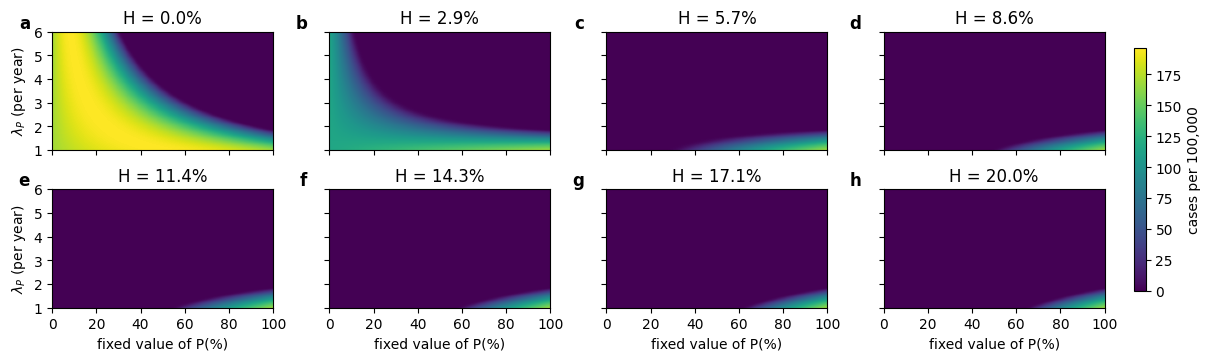

In [12]:
# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate([results[H]["res_infections"].flatten() for H in Hs])

global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

num_H = len(Hs)

# Set up the figure and axes
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_H // 2,
    figsize=(3 * num_H // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, H in enumerate(Hs):
    ax = axes.flat[idx]
    res_infections = results[H]["res_infections"]
    cax = ax.imshow(
        res_infections,
        origin="lower",
        aspect="auto",
        vmin=global_vmin,
        vmax=global_vmax,
        extent=[0, 100, 1 / 360, 6 / 360],
    )
    ax.set_title(f"H = {H * 100:.1f}%")

    # Set xlabels only on the bottom most subplots
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 20, 40, 60, 80, 100])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[40] * 100),
                int(Ps[80] * 100),
                int(Ps[120] * 100),
                int(Ps[160] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if idx % ncols == 0:
        ax.set_ylabel("$\lambda_P$ (per year)")
        ax.set_yticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
        ax.set_yticklabels(["1", "2", "3", "4", "5", "6"])
    else:
        ax.set_yticks([1 / 360, 2 / 360, 3 / 360, 4 / 360, 5 / 360, 6 / 360])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.15,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()

# Figures

## Endemic new infections (i.e., transitions from S to Ia + transitions from S to Is)

<>:61: SyntaxWarning: invalid escape sequence '\l'
<>:61: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\3512080588.py:61: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


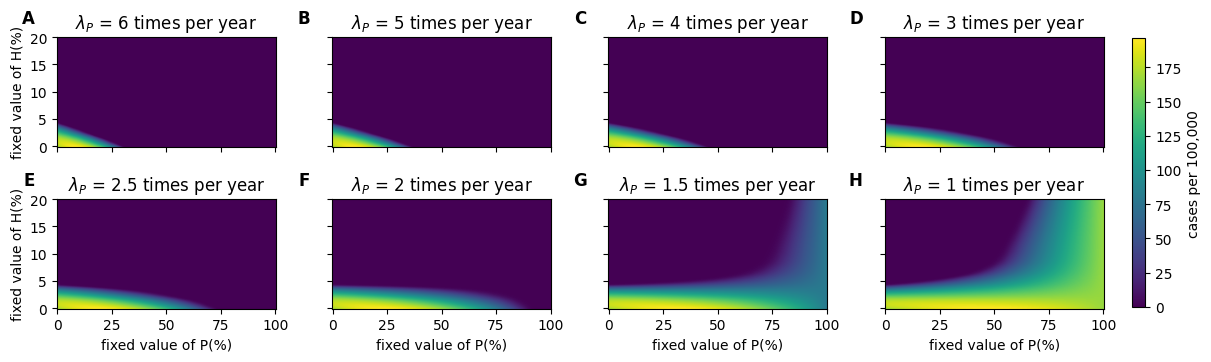

In [24]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_infections"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle(
#     "Endemic new infections (i.e., transitions from S to Ia + transitions from S to Is)"
# )


plt.show()

## Endemic new asymptomatic infections (i.e., transitions from S to Ia)

<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\1688687058.py:58: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


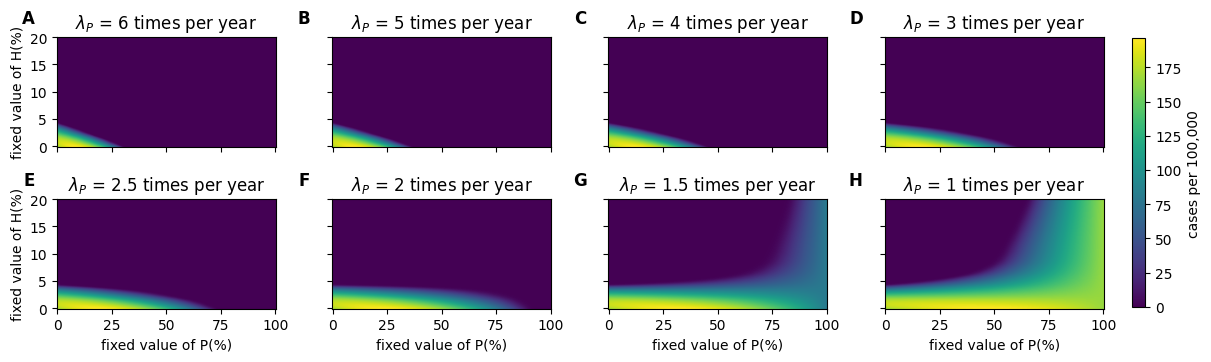

In [25]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [
        results[lambda_P]["res_asymp_infections"].flatten()
        for lambda_P in lambda_P_values
    ]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_asymp_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle(
#     "Endemic new asymptomatic infections (i.e., transitions from S to Ia)"
# )


plt.show()

## Endemic new symptomatic infections (i.e., transitions from S to Is)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\3383496280.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


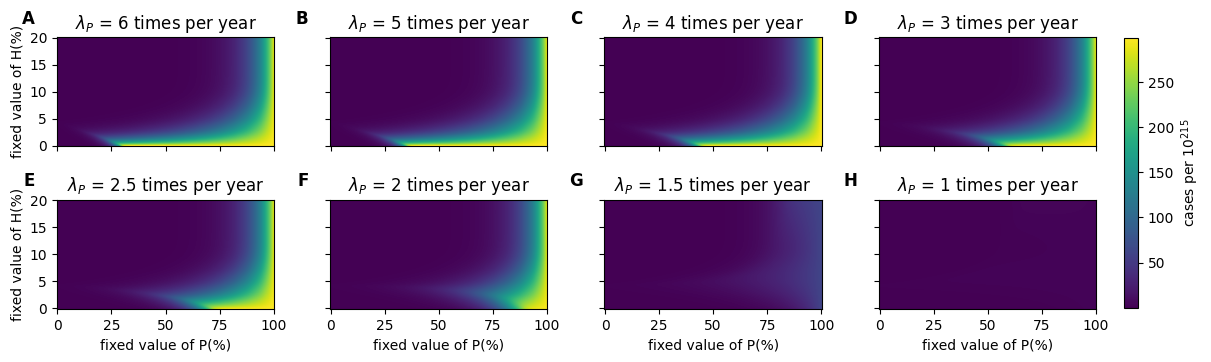

In [28]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e215:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_symp_infections"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_symp_infections"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per $10^{215}$")
# fig.suptitle(
#     "Endemic new symptomatic infections (i.e., transitions from S to Is)"
# )


plt.show()

## Detected new infections (i.e., transition from Ia to T + Is to T)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\678089972.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


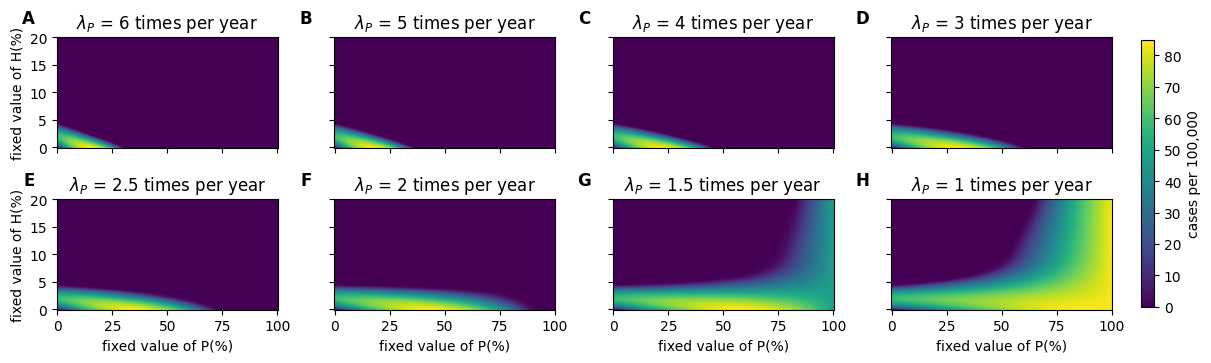

In [29]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")


# fig.suptitle("Detected new infections (i.e., transition from Ia to T + Is to T)")


plt.show()

## Detected new asymptomatic infections (i.e., transition from Ia to T)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\745018519.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


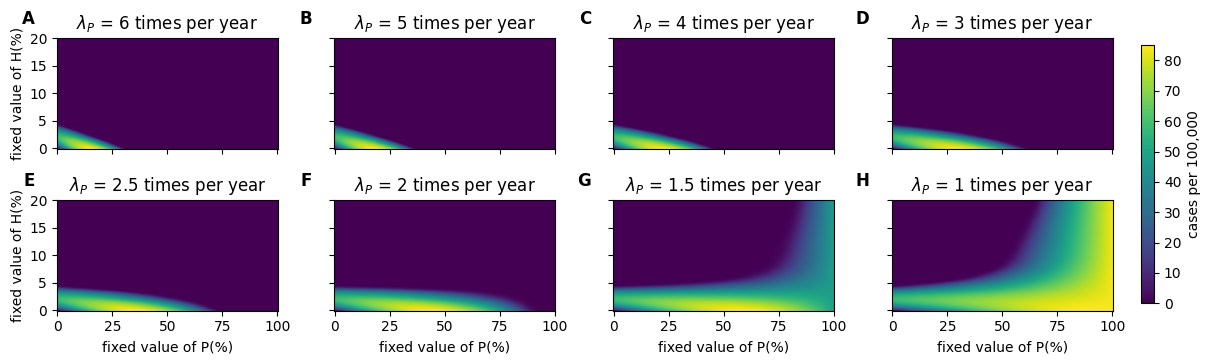

In [9]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_asymp_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_asymp_tests"]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.85,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")
# fig.suptitle("Detected new asymptomatic infections (i.e., transition from Ia to T)")

plt.show()

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:46: SyntaxWarning: invalid escape sequence '\l'
<>:71: SyntaxWarning: invalid escape sequence '\l'
<>:74: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:46: SyntaxWarning: invalid escape sequence '\l'
<>:71: SyntaxWarning: invalid escape sequence '\l'
<>:74: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_41436\3177367423.py:43: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda_P$")
C:\Users\PMallick\AppData\Local\Temp\ipykernel_41436\3177367423.py:46: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title("Dependency of Infections on $\lambda_P$, P, and H")
C:\Users\PMallick\AppData\Local\Temp\ipykernel_41436\3177367423.py:71: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("$\lambda_P$")
C:\Users\PMallick\AppData\Local\Temp\ipykernel_41436\3177367423.py:74: SyntaxWarning: invalid escape sequence '\l'
  

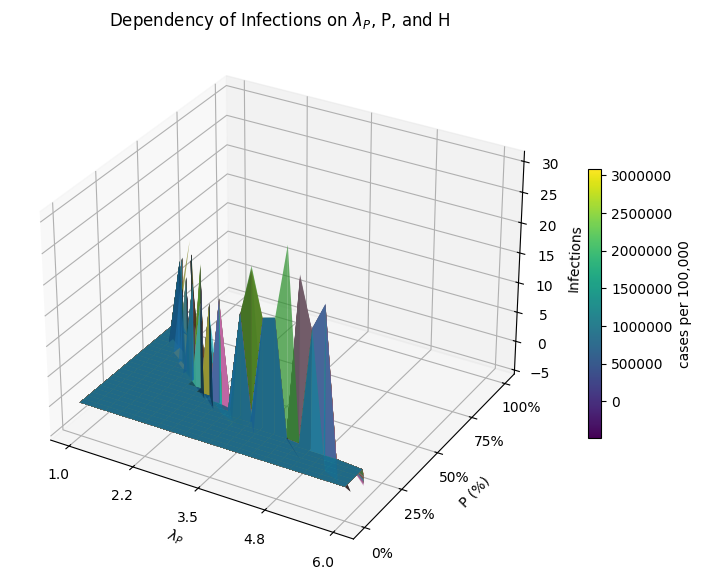

interactive(children=(IntSlider(value=0, description='H Index'), Output()), _dom_classes=('widget-interact',))

In [55]:
# # Define a formatter function that multiplies the value by 100,000
# def formatter(x, pos):
#     return f"{x * 1e5:.0f}"


# # Extract all infection data to determine global vmin and vmax
# all_infections = np.concatenate(
#     [results[lambda_P]["res_asymp_tests"].flatten() for lambda_P in lambda_P_values]
# )

# # global_vmin = np.min(all_infections)
# # global_vmax = np.max(all_infections)

# # Create a 3D plot
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection="3d")

# # Meshgrid for lambda_P, Ps, and Hs values
# Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
# Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0
# Lambda_P, P = np.meshgrid(lambda_P_values, Ps)

# # Collect data for each lambda_P, P, and H combination
# Z = np.array(
#     [
#         [results[lambda_P]["res_asymp_tests"][h, p] for lambda_P in lambda_P_values]
#         for p in range(len(Ps))
#         for h in range(len(Hs))
#     ]
# ).reshape(len(Ps), len(Hs), len(lambda_P_values))

# # Plot each surface
# for i, h in enumerate(Hs):
#     ax.plot_surface(Lambda_P, P, Z[:, i, :], label=f"H = {h* 1e5:.0f}%", alpha=0.7)

# # Add color bar
# mappable = plt.cm.ScalarMappable(cmap="viridis")
# mappable.set_array(all_infections)
# cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, format=FuncFormatter(formatter))
# cbar.ax.set_ylabel("cases per 100,000")

# # Set labels and title
# ax.set_xlabel("$\lambda_P$")
# ax.set_ylabel("P (%)")
# ax.set_zlabel("Infections")
# ax.set_title("Dependency of Infections on $\lambda_P$, P, and H")

# # Set x and y ticks for better readability
# ax.set_xticks(lambda_P_values[::5])
# ax.set_xticklabels([f"{x:.1f}" for x in lambda_P_values[::5]])
# ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_yticklabels([f"{x*100:.0f}%" for x in [0, 0.25, 0.5, 0.75, 1]])

# # plt.show()
# # Assuming your existing setup and data preparation code remains the same


# from matplotlib.ticker import FuncFormatter
# import ipywidgets as widgets
# from IPython.display import display


# # Function to update the plot
# def update_plot(h_index=0):
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection="3d")

#     # Only plot for a single H value based on the slider
#     ax.plot_surface(Lambda_P, P, Z[:, h_index, :], cmap="viridis", edgecolor="none")

#     ax.set_xlabel("$\lambda_P$")
#     ax.set_ylabel("P (%)")
#     ax.set_zlabel("Infections")
#     ax.set_title("Dependency of Infections on $\lambda_P$, P, and H")

#     ax.set_xticks(lambda_P_values[::5])
#     ax.set_xticklabels([f"{x:.1f}" for x in lambda_P_values[::5]])
#     ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
#     ax.set_yticklabels([f"{x*100:.0f}%" for x in [0, 0.25, 0.5, 0.75, 1]])

#     plt.show()


# # Create a slider widget for H values
# h_slider = widgets.IntSlider(
#     min=0, max=len(Hs) - 1, step=1, value=0, description="H Index"
# )

# # Display the widget and use `interactive_output` to update the plot based on the slider
# widgets.interactive(update_plot, h_index=h_slider)

## Detected new symptomatic infections (i.e., transition from Is to T)

<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:55: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\1414118137.py:55: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


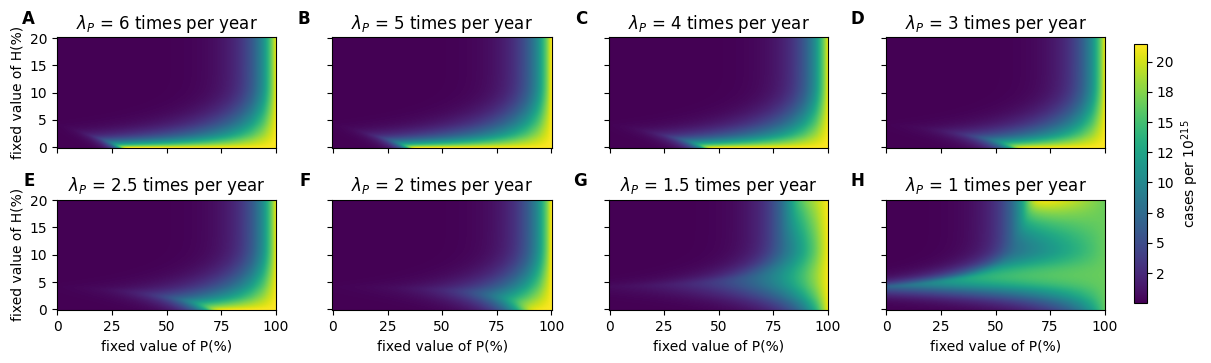

In [23]:
# Plotting


lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e215:.0f}"


# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P]["res_symp_tests"].flatten() for lambda_P in lambda_P_values]
)


global_vmin = np.min(all_infections)


global_vmax = np.max(all_infections)


num_lambda_P = len(lambda_P_values)

gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)


nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_symp_tests = results[lambda_P]["res_symp_tests"]
    cax = ax.imshow(res_symp_tests, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.85,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per $10^{215}$")
# fig.suptitle(
#     "Detected new symptomatic infections (i.e., transition from Is to T)"
# )


plt.show()

## Lambda STI

<>:59: SyntaxWarning: invalid escape sequence '\l'
<>:59: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\3005773729.py:59: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


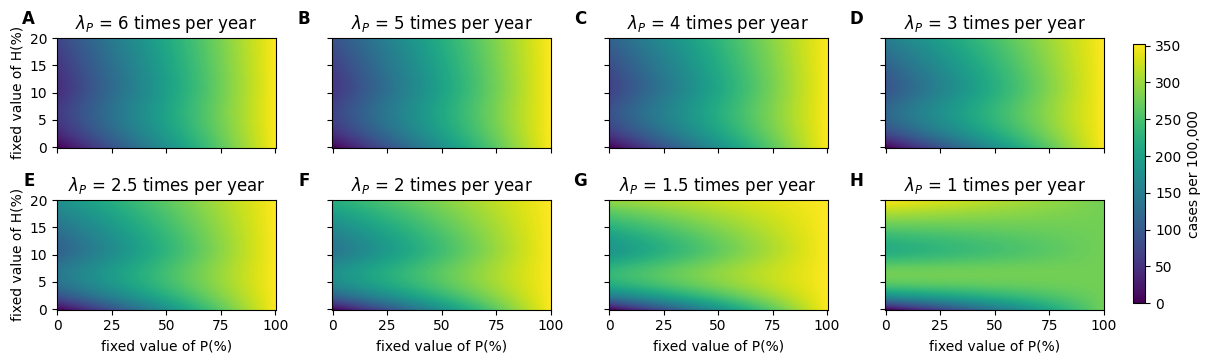

In [34]:
# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

num_lambda_P = len(lambda_P_values)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P_val in enumerate(lambda_P_values):

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = compute_m(args, H)
            lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)
            lambda_P[i, j] = lambda_P_val * P

    ax = axes.flat[idx]
    total_lambda = lambda_P + lambda_H + args["lambda_0_a"]
    cax = ax.imshow(total_lambda, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.85,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

# fig.suptitle(
#     "$\lambda_{STI}$ = $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",
#     fontweight="bold",
# )

plt.show()

## Lambda H

<>:61: SyntaxWarning: invalid escape sequence '\l'
<>:61: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\135784899.py:61: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


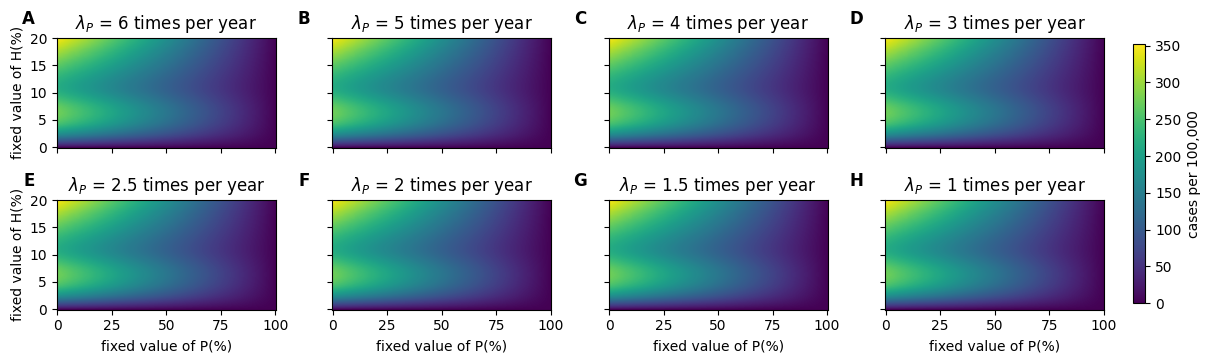

In [40]:
# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

num_lambda_P = len(lambda_P_values)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])

# Store m values for each H
m_values = np.zeros(len(Hs))

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P_val in enumerate(lambda_P_values):

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            m = compute_m(args, H)
            m_values[i] = m
            lambda_H[i, j] = args["c"] * (1 - m) * args["beta_HIV"] * H * (1 - P)

    ax = axes.flat[idx]
    cax = ax.imshow(lambda_H, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.85,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

# fig.suptitle(
#     "$\lambda_H \cdot (1-P) $",
#     fontweight="bold",
# )

plt.show()

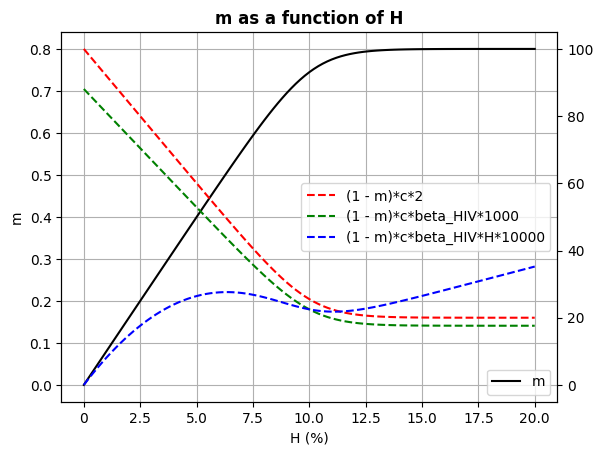

In [103]:
# Plot m values as a function of H
fig, ax = plt.subplots(1, 1)
dummy_P = np.linspace(0, 1, 101)
axR = ax.twinx()
ax.plot(Hs, m_values, color="black", label="m")
axR.plot(
    Hs,
    ((1 - m_values) * args["c"] * 2),
    color="red",
    linestyle="--",
    label="(1 - m)*c*2",
)
axR.plot(
    Hs,
    (args["c"] * (1 - m_values) * args["beta_HIV"] * 1000),
    color="green",
    linestyle="--",
    label="(1 - m)*c*beta_HIV*1000",
)
axR.plot(
    Hs,
    (args["c"] * (1 - m_values) * args["beta_HIV"] * Hs * 10000),
    color="blue",
    linestyle="--",
    label="(1 - m)*c*beta_HIV*H*10000",
)
ax.set_xlabel("H (%)")
ax.set_ylabel("m")
ax.set_title("m as a function of H", fontweight="bold")
ax.set_xticks([0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200])
ax.set_xticklabels(
    [
        "0",
        "2.5",
        "5.0",
        "7.5",
        "10.0",
        "12.5",
        "15.0",
        "17.5",
        "20.0",
    ]
)
ax.grid(True)
ax.legend(loc="lower right")
axR.legend(loc="center right")

## Lambda P

<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33996\2185468381.py:56: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


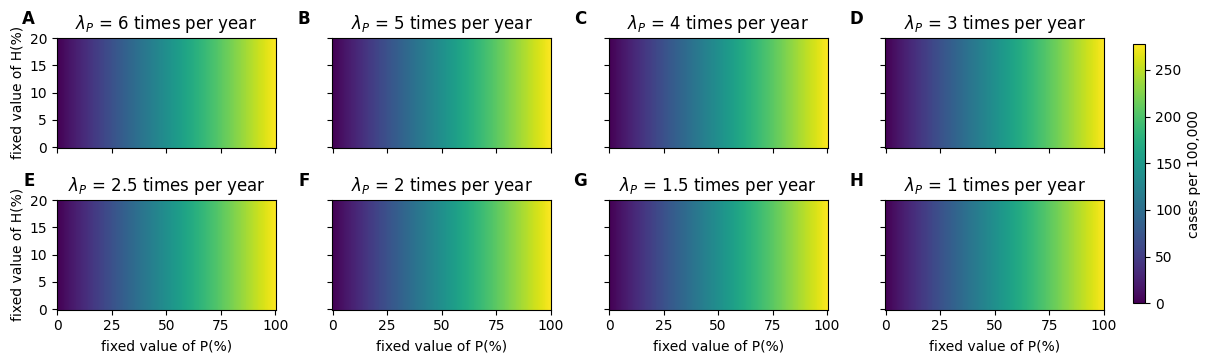

In [39]:
# Define m function
def compute_m(args, H):
    return args["m_max"] - args["m_max"] / args["H_thres"] * args["m_eps"] * np.log(
        1 + np.exp((args["H_thres"] - H) / args["m_eps"])
    )


# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

Hs = np.linspace(0, 0.2, 101)  # 101 points from 0 to 0.2
Ps = np.linspace(0, 1.0, 201)  # 201 points from 0 to 1.0


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

num_lambda_P = len(lambda_P_values)
lambda_H = np.zeros([len(Hs), len(Ps)])
lambda_P = np.zeros([len(Hs), len(Ps)])

nrows, ncols = axes.shape  # Assuming axes is a 2D array of subplots
for idx, lambda_P_val in enumerate(lambda_P_values):

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            lambda_P[i, j] = lambda_P_val * P

    ax = axes.flat[idx]
    cax = ax.imshow(lambda_P, origin="lower")
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )

# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.85,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

# fig.suptitle(
#     "$\lambda_{STI}$ = $\lambda_H \cdot (1-P) $ + $\lambda_P \cdot P$",
#     fontweight="bold",
# )

plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\l'
<>:26: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_42928\3164157755.py:26: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")


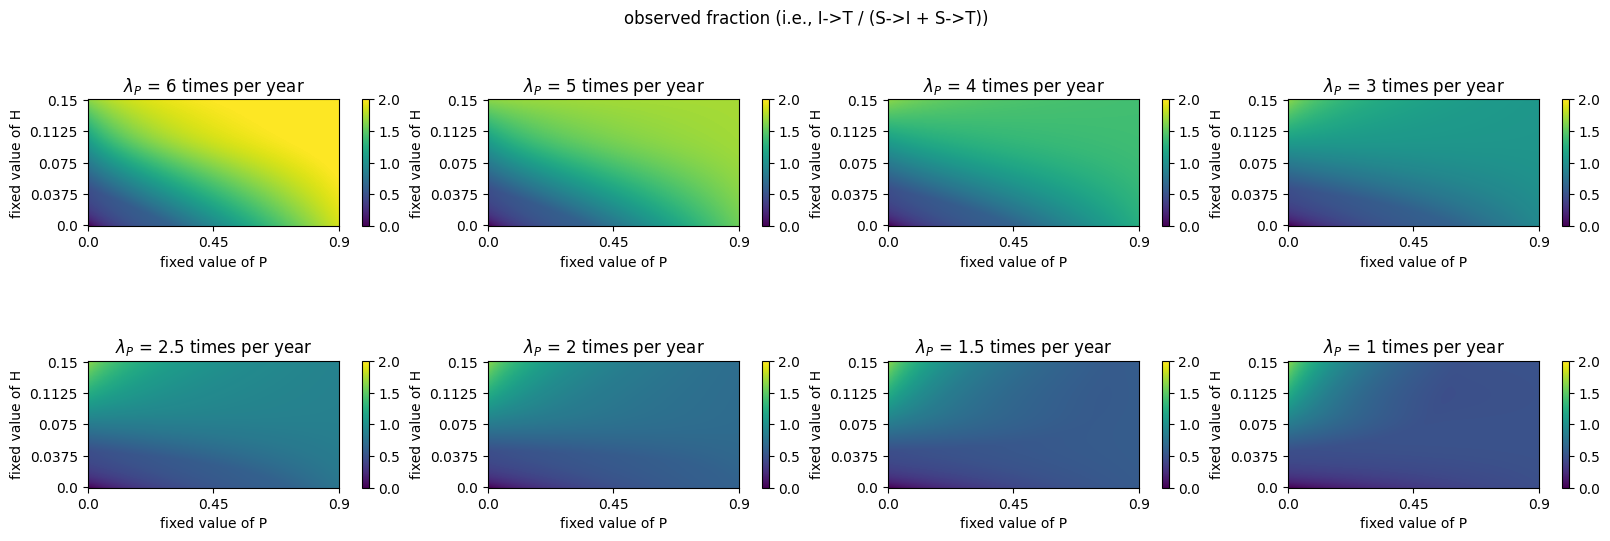

In [7]:
Hs = np.linspace(0, 0.15, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 5.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]["res_infections"]
    res_tests = results[lambda_P]["res_tests"]
    cax = ax.imshow(res_tests / res_infections, origin="lower", vmin=0, vmax=2)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction (i.e., I->T / (S->I + S->T))")

plt.show()

In [ ]:
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 0.9, 201)
# Plotting
lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]
num_lambda_P = len(lambda_P_values)
fig, axes = plt.subplots(
    2, num_lambda_P // 2, figsize=(4 * num_lambda_P // 2, 4.5), constrained_layout=True
)


for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_I = results[lambda_P]["res_I"]
    res_T = results[lambda_P]["res_T"]
    cax = ax.imshow(res_I - res_T, origin="lower", vmin=0, vmax=0.7)
    ax.set_title(f"$\lambda_P$ = {lambda_P_labels[idx]}")
    ax.set_xlabel("fixed value of P")
    ax.set_ylabel("fixed value of H")
    ax.set_xticks([0, 100, 200])
    ax.set_xticklabels([Ps[0], 0.45, Ps[200]])
    ax.set_yticks([0, 25, 50, 75, 100])
    ax.set_yticklabels([Hs[0], Hs[25], Hs[50], Hs[75], Hs[100]])
    fig.colorbar(cax, ax=ax, shrink=0.5)
fig.suptitle("observed fraction T/(T+I)")

plt.show()